## Import GTZAN Dataset and Package Dependencies

* A collection of 10 genres with 100 audio files each, all having a length of 30 seconds. (includes mel spectograms for each audio sample)
* download the dataset [here](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/data), then upload the dataset folder to google drive and update `root_dir_path` below

### Software Requirements
* fetches pip packages
* initializes dataset path and genre list

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy, sys, os, pickle, random
import librosa, librosa.display
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dropout, Dense, Conv2D, MaxPool2D, Flatten, Reshape, BatchNormalization, GlobalAveragePooling2D # layers I will incorporate
from keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG19
from sklearn.metrics import confusion_matrix
from keras import backend
from google.colab import drive

drive.mount('/content/drive')
# Update this string to your path
root_dir_path = '/content/drive/MyDrive/'
genres = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]

Mounted at /content/drive


# Deep Feed-Forward Artificial Neural Net (ANN) Model



## Preparing Raw Audio Files
* spectral
* melfrequency cepstral coefficients
* mean/var
* 58 features total
* Adapted From: https://www.kaggle.com/code/andradaolteanu/work-w-audio-data-visualise-classify-recommend/notebook


## Exploratory Data Analysis

#### Initial Findings

* filename provides no information for the learner, and length is the same for every row, so we drop both from the table.

* some values such as *perceptr_var* have a very low mean (5.601553e-03) while others have large means such as *mfcc2_var* (588.79) so we need to standardize the data.

* *labels* target variable is alphanumeric encoded, so we'll need to transform the class labels to integers

### Import the Data

In [ ]:
file_path_three_sec = f"{root_dir_path}/GTZAN/Data/features_3_sec.csv"
file_path_thirty_sec = f"{root_dir_path}/GTZAN/Data/features_30_sec.csv"

# make pandas df, for 3/30 second samples
three_sec_features = pd.read_csv(file_path_three_sec)
thirty_sec_features = pd.read_csv(file_path_thirty_sec)
three_sec_features.head()

# drop filename/length
three_sec_features = three_sec_features.drop(labels=['filename', 'length', 'label'], axis=1)
thirty_sec_features = thirty_sec_features.drop(labels=['filename', 'length', 'label'], axis=1)

### Basic Stats: Mean/Std. Dev

In [ ]:
three_sec_features.describe()

chroma_stft_mean  chroma_stft_var     rms_mean  ...   mfcc19_var  mfcc20_mean   mfcc20_var
count       9990.000000      9990.000000  9990.000000  ...  9990.000000  9990.000000  9990.000000
mean           0.379534         0.084876     0.130859  ...    54.973829    -0.917584    57.322614
std            0.090466         0.009637     0.068545  ...    41.585677     5.253243    46.444212
min            0.107108         0.015345     0.000953  ...     3.065302   -35.640659     0.282131
25%            0.315698         0.079833     0.083782  ...    30.496412    -4.004475    30.011365
50%            0.384741         0.085108     0.121253  ...    43.435253    -1.030939    44.332155
75%            0.442443         0.091092     0.176328  ...    65.328602     2.216603    68.210421
max            0.749481         0.120964     0.442567  ...  1143.230591    34.212101   910.473206

[8 rows x 57 columns]

### Visual Correlation Matrix (3-sec samples)

<Axes: >

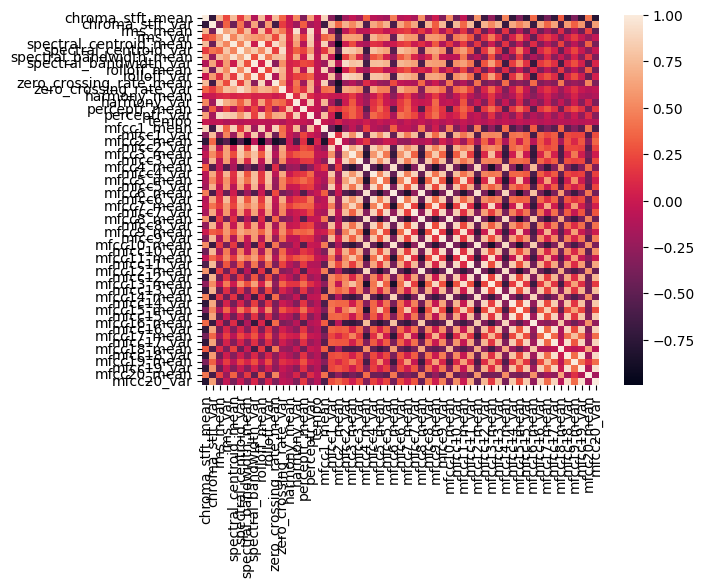

In [ ]:
sns.heatmap(three_sec_features.corr().corr(), xticklabels=three_sec_features.corr().columns.tolist(), yticklabels=three_sec_features.corr().columns.tolist(),)

### Visual Correlation Matrix (30-second samples)

<Axes: >

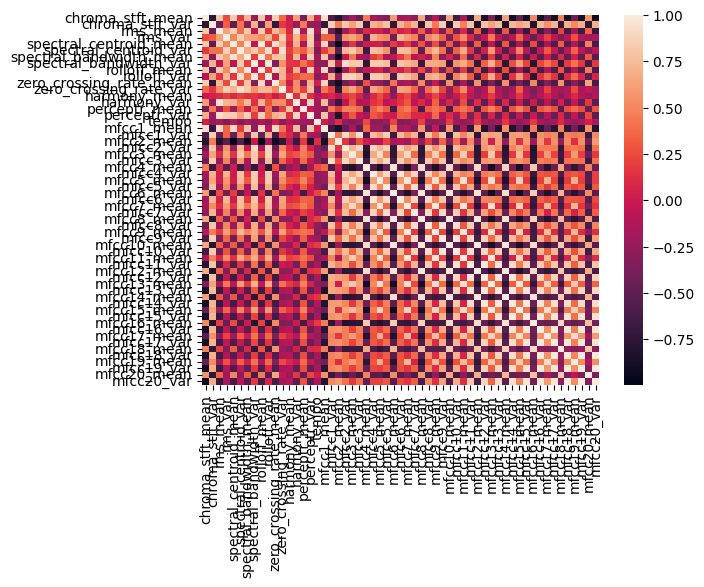

In [ ]:
sns.heatmap(thirty_sec_features.corr().corr(), xticklabels=thirty_sec_features.corr().columns.tolist(), yticklabels=thirty_sec_features.corr().columns.tolist(),)

## Dataset Preprocessing

* transform label strings to integer labels
* standardize the data

In [ ]:
# fresh read, to reinit the labels
three_sec_features = pd.read_csv(file_path_three_sec).drop(labels=['filename', 'length'], axis=1)
thirty_sec_features = pd.read_csv(file_path_thirty_sec).drop(labels=['filename', 'length'], axis=1)

# transform label strings to integers
y_three_sec = LabelEncoder().fit_transform(three_sec_features.iloc[:, -1])
y_thirty_sec = LabelEncoder().fit_transform(thirty_sec_features.iloc[:, -1])

# remove labels
three_sec_features = three_sec_features.drop(labels=['labels'], axis=1)
thirty_sec_features = thirty_sec_features.drop(labels=['labels'], axis=1)

# check results
print(y_three_sec)

# standardize with mean and unit variance
fit = StandardScaler()
# X_three_sec = fit.fit_transform(np.array(three_sec_features, dtype=float))
X_thirty_sec = fit.fit_transform(np.array(thirty_sec_features, dtype=float))
X_train, X_test, y_train, y_test = train_test_split(X_thirty_sec, y_thirty_sec, test_size=0.2)

array([0, 0, 0, ..., 9, 9, 9])

## Split Data into Train/Val/Test

* We have a fully balanced dataset, each genre has the same number of audio samples as the other.
* Note: we train on the full 30 second audio clips for each song rather than the 3 second samples of each 30 second song clip to avoid poisioning the validation/test set with audio clips from songs seen in the training set.
* WIP: show the impact of this error, also provide a function that solves it show 3_second performance
* If you wish to use the 3 second samples, employ a technique to ensure the samples of the same 30-second audio clips are not included in the other datasets.

In [ ]:
# divide training into validation set
val_size = int(X_train.shape[0]*0.2)
X_val = X_train[-val_size:]
y_val = y_train[-val_size:]
X_train = X_train[:-val_size]
y_train = y_train[:-val_size]

print(f"Training Data Shape: {X_train.shape}")
print(f"Validation Data Shape: {X_val.shape}")
print(f"Test Data Shape: {X_test.shape}")

Training Data Shape: (640, 57)
Validation Data Shape: (160, 57)
Test Data Shape: (200, 57)


## ANN Model
* saves the model weights in /mgr_models/ann_{*current time*}

In [ ]:
from keras.models import Sequential
from datetime import datetime

# save the best weights
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    os.getcwd()+f"/mgr_models/ann_{datetime.now()}",
    monitor='accuracy',
    verbose=1,
    save_best_only=True,
)
# use cross-entropy loss, accuracy as metric
def train(model, batch_size, epochs, optimizer):
  model.compile(
      optimizer=optimizer,
      loss='sparse_categorical_crossentropy',
      metrics='accuracy')
  return model.fit(
      X_train,
      y_train,
      validation_data=(X_val, y_val),
      epochs=epochs,
      batch_size=batch_size,
      callbacks=[checkpoint])

def plot_validation(history):
  print("Validation Accuracy: ", max(history.history["val_accuracy"]))
  pd.DataFrame(history.history).plot(figsize=(10, 8))
  plt.show()

# define model
model = Sequential([
    keras.layers.Dense(512, activation="relu", input_shape=(X_train.shape[1], )),
    keras.layers.Dropout(0.2),

    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dropout(0.2),

    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.2),

    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.2),

    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dropout(0.2),

    keras.layers.Dense(10, activation="softmax")
])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               29696     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8

### Performance Evaluation

Epoch 1/500
5/5 [==============================] - 2s 86ms/step - loss: 2.2252 - accuracy: 0.1906 - val_loss: 2.0978 - val_accuracy: 0.2500
Epoch 2/500
5/5 [==============================] - 0s 34ms/step - loss: 2.0999 - accuracy: 0.2469 - val_loss: 1.9999 - val_accuracy: 0.2937
Epoch 3/500
5/5 [==============================] - 0s 29ms/step - loss: 2.0223 - accuracy: 0.2562 - val_loss: 1.8871 - val_accuracy: 0.3000
Epoch 4/500
5/5 [==============================] - 0s 27ms/step - loss: 1.9219 - accuracy: 0.2906 - val_loss: 1.7892 - val_accuracy: 0.3438
Epoch 5/500
5/5 [==============================] - 0s 27ms/step - loss: 1.8531 - accuracy: 0.3094 - val_loss: 1.7522 - val_accuracy: 0.3500
Epoch 6/500
5/5 [==============================] - 0s 28ms/step - loss: 1.8112 - accuracy: 0.3359 - val_loss: 1.7219 - val_accuracy: 0.3625
Epoch 7/500
5/5 [==============================] - 0s 31ms/step - loss: 1.7633 - accuracy: 0.3344 - val_loss: 1.6898 - val_accuracy: 0.3875
Epoch 8/500
5/5 [===

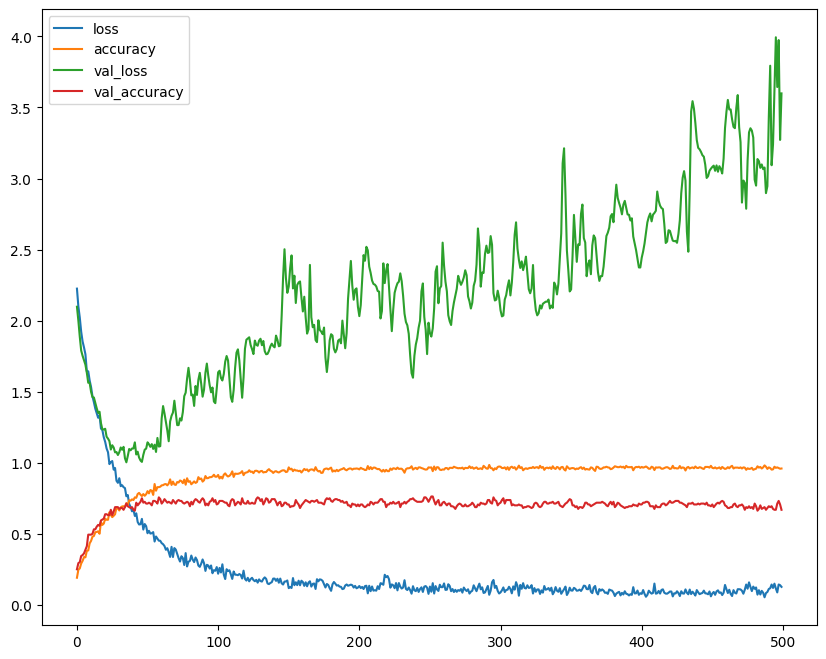

In [ ]:
model_history = train(model=model, batch_size=128, epochs=500, optimizer="adam")
plot_validation(model_history)

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=128)
print("Test Loss", test_loss)
print("Test Accuracy", test_accuracy)

2/2 [==============================] - 0s 9ms/step - loss: 2.9153 - accuracy: 0.7350
Test Loss 2.915346145629883
Test Accuracy 0.7350000143051147


# CNN Melspectogram based model

## Preparing Raw Audio Files
* need to generate melspectogram for each audio file
* WIP: output should be a **432x288** png image

### Generate Spectograms from **.wav** files

In [7]:
def generate_melspec_from_wav(
      file_path,
      n_fft=2048,
      hop_length=512,
      n_mels=128,
      power=4.0,
      verbose=False):
  '''
  Returns a melspectogram from a given wav file.
    n_fft:      (int)   length of the FFT window
    hop_length: (int)   number of samples between frames
    n_mels:     (int)   number of bins to split frequency spectrum into
    power:      (float) exponent to raise magnitude of frequency
    verbose:    (bool)  will display and image of the melspectogram.

  '''
  # convert to bytes and trim the empty sounds
  data, sample_rate = librosa.load(file_path)
  trimmed_data, _ = librosa.effects.trim(data)

  # performs Short-Time Fourier Transformer in Mel-scale
  mel_spect = librosa.feature.melspectrogram(
      y=trimmed_data,
      sr=sample_rate,
      n_fft=n_fft,
      hop_length=hop_length,
      n_mels=n_mels,
      power=4.0,)

  # convert exponential amplitude to log scale
  mel_spect = librosa.power_to_db(mel_spect, ref=np.max)

  if verbose:
    plt.figure(figsize = (5, 3))
    plt.title(file_path.replace(f"{root_dir_path}/GTZAN/Data/genres_original/", ""))
    librosa.display.specshow(
        mel_spect,
        sr=sample_rate,
        hop_length=hop_length,
        x_axis='time',
        y_axis='hz',)
    plt.colorbar();
  return mel_spect

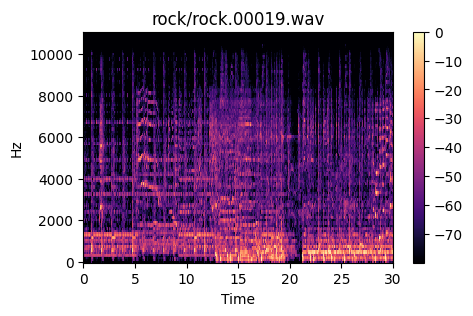

In [9]:
# load sample audio file from dataset
file_path = f"{root_dir_path}/GTZAN/Data/genres_original/rock/rock.00019.wav"
melspec = generate_melspec_from_wav(file_path=file_path, verbose=True)

Comparison to provided spectogram

(288, 432, 3)


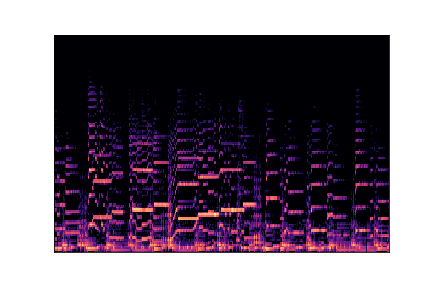

In [ ]:
from IPython.display import display
from PIL import Image
import cv2


path=f"{root_dir_path}/GTZAN/Data/images_original/jazz/jazz00019.png"
jazz_spect_img = Image.open(path)
im = cv2.imread(path)
print(im.shape)
display(jazz_spect_img)

## Exploratory Data Analysis

### Sample Audio

In [ ]:
audio_sample = f"{root_dir_path}/GTZAN/Data/genres_original/jazz/jazz.00031.wav"
# decodes audio as a time series, with sample rate
data, sample_rate = librosa.load(audio_sample)
Audio(data, rate=sample_rate)

### Visualizing Audio Waveforms

Show the change in a signals amplitude (y-axis) versus time (x-axis). Helps to visualize changes in loudness/signal intensity.


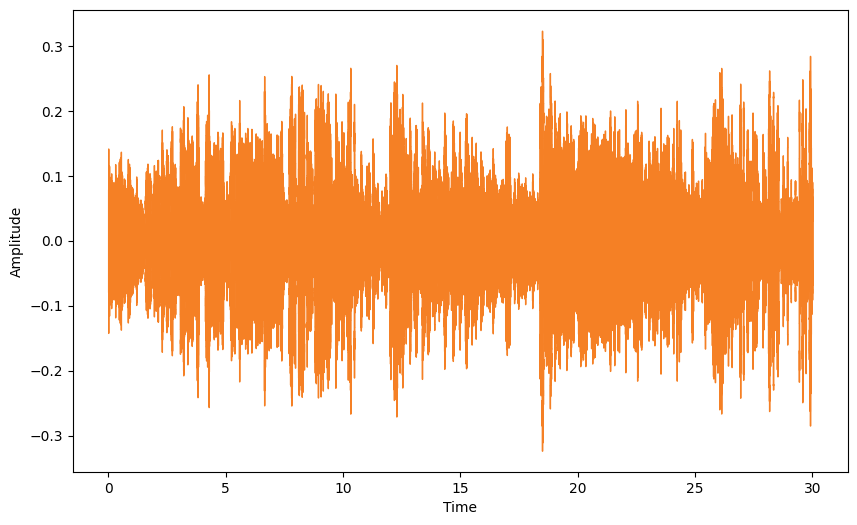

In [ ]:
plt.figure(figsize=(10, 6))
plt.xlabel("Time")
plt.ylabel("Amplitude")
librosa.display.waveshow(data, color="#f58025")
plt.show()

### Visualizing Audio Spectograms

Displays changes in the frequencies (y-axis) in a signal over time (x-axis). Amplitude is represented on a third dimension (z-axis) with different colors and varied brightness.

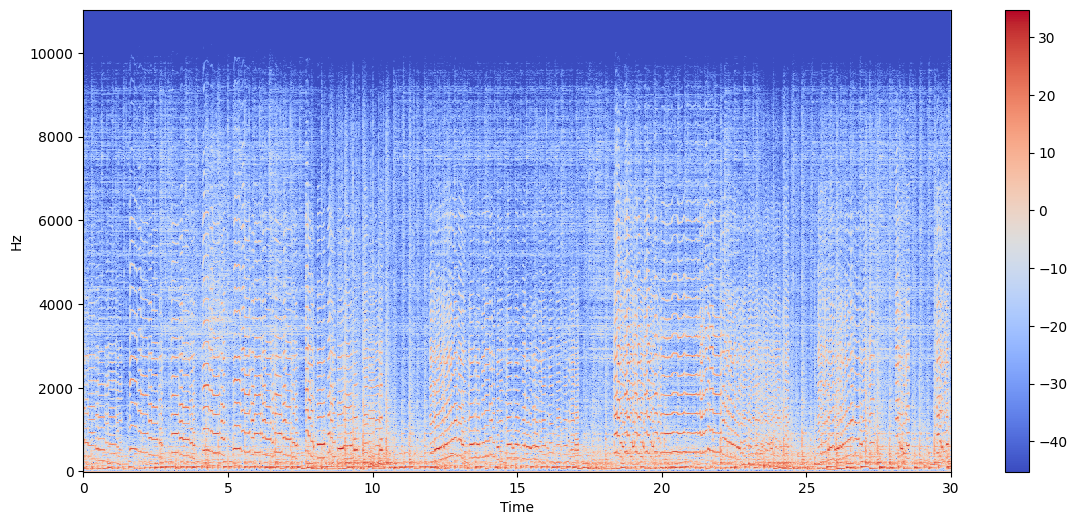

In [ ]:
# compute short-time fourier transform
stft = librosa.stft(data)
stft_db = librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(14,6))
librosa.display.specshow(stft_db, sr=sample_rate, x_axis="time", y_axis="hz")
plt.colorbar()

### Inspecting Provided Spectograms
* file 'jazz.00054.wav'in genres_original is corrupted and doesn't have a spectogram
* let's trim the (slightly) imbalanced dataset from 999 samples to 99 of each genre, for a total of **990** audio samples.

In [ ]:
# Data Inspection
dir_path = f"{root_dir_path}/GTZAN/Data/images_original"
genres = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]

for genre in genres:
  this_genre_dir_path = os.path.join(dir_path, genre)
  pngs_in_dir = [i for i in os.listdir(this_genre_dir_path) if i[-4:] == ".png"]
  print(f"Size of {genre} dataset: {len(pngs_in_dir)} files.")

Size of blues dataset: 100 files.
Size of classical dataset: 100 files.
Size of country dataset: 100 files.
Size of disco dataset: 100 files.
Size of hiphop dataset: 100 files.
Size of jazz dataset: 99 files.
Size of metal dataset: 100 files.
Size of pop dataset: 100 files.
Size of reggae dataset: 100 files.
Size of rock dataset: 100 files.


## Preprocessing the data
* trim dataset to 99 samples from each genre, n = **990** (see EDA above)
* standardized pixel values from [0,255] -> [0,1]
* Citation: https://www.kaggle.com/code/jamesslay/music-genre-classification-cnn-models

### Function def.
* splits spectogram pngs into train/test set
* splits spectogram pngs into k-folds train set

#### Set fixed Random Seed
* Citation: https://www.kaggle.com/code/jamesslay/music-genre-classification-cnn-models

In [2]:
def set_random():
    seed = 0 # random seed value
    os.environ["PYTHONHASHSEED"] = str(seed) # if this is not set, a random value is used to seed the hashes of some objects
    random.seed(seed) # sets the base python and numpy random seeds
    np.random.seed(seed)
    tf.random.set_seed(seed) # sets the tensorflow random seed
    tf.compat.v1.set_random_seed(seed)

#### Prepare Datasets
* splits the spectogram pngs into train/test dictionary with genres as keys
* defines fold functions (create, check valid)

In [17]:
import glob
import random

set_random()
# removes 1% of the data (10 samples)
split = [89, 10]
spectogram_train, spectogram_test = {}, {}
dictionaries = [spectogram_train, spectogram_test]
dir_path = f"{root_dir_path}/GTZAN/Data/images_original"

# splits the png files into separate dictionaries by genre
for d in dictionaries:
  # assign slice of data array
  if d == spectogram_train: num = slice(0, split[0])
  # elif d == spectogram_val: num = slice(split[0], split[0] + split[1])
  else: num = slice(split[0], split[0] + split[1])

  for genre in genres:
     path = os.path.join(dir_path, genre)
     pngs = glob.glob(os.path.join(path, "*.png"))
     # take this slice of files
     selected_files = pngs[num]
     # store file paths for genre in dictionary
     d[genre] = selected_files

len_dictionaries = [{genre: len(d[genre]) for genre in genres} for d in dictionaries]

# Confirm each genre has 80 training samples, 9 validation samples and 10 test samples
print(f"\033[1mTraining:\033[0m {len_dictionaries[0]}")
# print(f"\033[1mValidation:\033[0m {len_dictionaries[1]}")
print(f"\033[1mTest:\033[0m {len_dictionaries[1]}")

# splits the prepared training dataset into folds for cross-validation
def get_training_data_fold(n_folds):
  k_folds = []
  n_training_samples = split[0]/100 * 1000
  # each fold should have an equal or as close to equal #of observations
  n_items_in_fold = n_training_samples / n_folds
  additional_items_in_last_fold = n_training_samples % n_folds

  # randomize the datatest
  shuffled_training_dataset = {}
  for genre, genre_images in spectogram_train.items():
    if genre not in shuffled_training_dataset:
      imgs_copy = genre_images.copy()
      random.shuffle(imgs_copy)
      shuffled_training_dataset[genre] = imgs_copy

  # assign files to different folds
  for fold in range(n_folds):
    max_items = n_items_in_fold + additional_items_in_last_fold if fold == n_folds-1 else n_items_in_fold
    fold_dict = {}
    n_items = 0
    img_ind = 0
    # grab a sample from each genre until the fold is full
    while n_items < max_items:
      for genre, genre_images in shuffled_training_dataset.items():
        if genre not in fold_dict:
          fold_dict[genre] = []
        if len(genre_images) > img_ind:
          fold_dict[genre].append(genre_images[img_ind])
          n_items += 1
        # check current length while looping through genres
        if n_items == max_items:
          break
      img_ind += 1
    k_folds.append(fold_dict)

  return k_folds

def check_folds(folds, training_dataset_size, verbose=False):
  fold_dictionaries = [{genre: len(d[genre]) for genre in genres} for d in folds]
  total_samples = 0
  for i in range(len(fold_dictionaries)):
    for genre, n_samples in fold_dictionaries[i].items():
    # print(fold_dictionaries[i].items())
      total_samples += n_samples
    if verbose:
      print(f"\033[1mFold {i}:\033[0m {fold_dictionaries[i]}")
      print(f"\033[1mTotal Samples:\033[0m {total_samples}")
  return total_samples == training_dataset_size

Training: {'blues': 89, 'classical': 89, 'country': 89, 'disco': 89, 'hiphop': 89, 'jazz': 89, 'metal': 89, 'pop': 89, 'reggae': 89, 'rock': 89}
Test: {'blues': 10, 'classical': 10, 'country': 10, 'disco': 10, 'hiphop': 10, 'jazz': 10, 'metal': 10, 'pop': 10, 'reggae': 10, 'rock': 10}


### Format the data for Tensorflow
* standardizes data
* changes string labels to ints
* creates training/test datasets
  * Note: resizes each image to be (288, 432)

In [18]:
genre_map = {
    "blues": 0,
    "classical": 1,
    "country": 2,
    "disco": 3,
    "hiphop": 4,
    "jazz": 5,
    "metal": 6,
    "pop": 7,
    "reggae": 8,
    "rock": 9
}
inverse_genre_map = {value: key for key, value in genre_map.items()}
batch_size = 32

def create_dataset(d):
  # 288 rows (img height) x 432 columns (img width [time axis])
  img_size = (288, 432)
  image_list, label_list = [], []

  for genre, paths in d.items():
    for path in paths:
      image = tf.cast(
          tf.image.resize(
              tf.image.decode_png(tf.io.read_file(path), channels=3),
              img_size),
          tf.float32)
      # normalize pixel values [0,1]
      image /= 255
      image_list.append(image)
      # update label to integer
      label_list.append(genre_map[genre])
      # print(keras.utils.to_categorical(genre_map[genre]))
  dataset = tf.data.Dataset.from_tensor_slices((image_list, keras.utils.to_categorical(label_list)))
  dataset = dataset.shuffle(buffer_size=len(image_list)).batch(batch_size)
  return dataset, image_list

def prepare_dataset(ds_image_list):
  ds = ds_image_list[0]
  image_list = ds_image_list[1]
  out = (
      # convert img tensor to floats
      ds.map(lambda image, label: (tf.image.convert_image_dtype(image, tf.float32), label))
      # optimizations
      .cache()
      .shuffle(buffer_size=len(image_list))
      .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  )
  return out

# need to prep the dataset from genre/[filepath] dictionaries
training = prepare_dataset(create_dataset(spectogram_train))
# validation = prepare_dataset(create_dataset(spectogram_val))
testing = prepare_dataset(create_dataset(spectogram_test))

## Transfer Learning VGG-19

### Building the Model
* adds custom classifier head to vgg-19
* performance eval w/K-fold cross validation


#### Import and Inspect VGG-19

In [34]:
# import vgg19 model
conv_base = VGG19(
    weights = "imagenet",
    include_top = False,
    input_shape = (288, 432, 3),
    pooling=None,
)
print(conv_base.summary())

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 288, 432, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 288, 432, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 288, 432, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 144, 216, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 144, 216, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 144, 216, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 72, 108, 128)      0     

#### Freeze base model and add a new head

In [35]:
# freeze base model and add a new head
conv_base.trainable = False

# regularization hyperparam
reg = 0.0001

# converts images to BGR and scales each color-channel w.r.t ImageNet
inputs = keras.Input(shape=(288, 432, 3))
x = keras.applications.vgg19.preprocess_input(inputs)
x = conv_base(inputs)
x = keras.layers.Flatten()(x)
# add a new head
x = keras.layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(reg))(x)
# x = keras.layers.Dense(256, activation="relu")(x)
outputs = keras.layers.Dense(len(genres), activation="softmax")(x)
model = keras.Model(inputs, outputs)

# prep and train the model
model.compile(
    # run_eagerly=True,
    loss="categorical_crossentropy",
    optimizer="rmsprop",
    metrics=[keras.metrics.AUC(), keras.metrics.F1Score(), keras.metrics.CategoricalAccuracy()])

print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 288, 432, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 9, 13, 512)        20024384  
                                                                 
 flatten_2 (Flatten)         (None, 59904)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               15335680  
                                                                 
 dense_5 (Dense)             (None, 10)                2570      
                                                                 
Total params: 35362634 (134.90 MB)
Trainable params: 15338250 (58.51 MB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________
None


### Evaluating Testset Performance
* fits the model to the full training dataset
* saves checkpointed weights in 'mgr_models/vgg19_head_only_{*current time*}
* runs inference on the test dataset

#### Model Training
* fits the full training dataset to the model, with best hyperparams from k-folds

Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 15.2864 - auc: 0.5525 - f1_score: 0.1514 - categorical_accuracy: 0.1550
Epoch 1: categorical_accuracy improved from -inf to 0.15500, saving model to /content/drive/MyDrive//mgr_models/vgg19_head_only_2024-04-22 09:08:52.856928
25/25 [==============================] - 24s 401ms/step - loss: 15.2864 - auc: 0.5525 - f1_score: 0.1514 - categorical_accuracy: 0.1550
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 3.5073 - auc: 0.7035 - f1_score: 0.3006 - categorical_accuracy: 0.3038
Epoch 2: categorical_accuracy improved from 0.15500 to 0.30375, saving model to /content/drive/MyDrive//mgr_models/vgg19_head_only_2024-04-22 09:08:52.856928
25/25 [==============================] - 9s 376ms/step - loss: 3.5073 - auc: 0.7035 - f1_score: 0.3006 - categorical_accuracy: 0.3038
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 3.1202 - auc: 0.7402 - f1_score: 0.3235 - categorical_accuracy: 0.3212

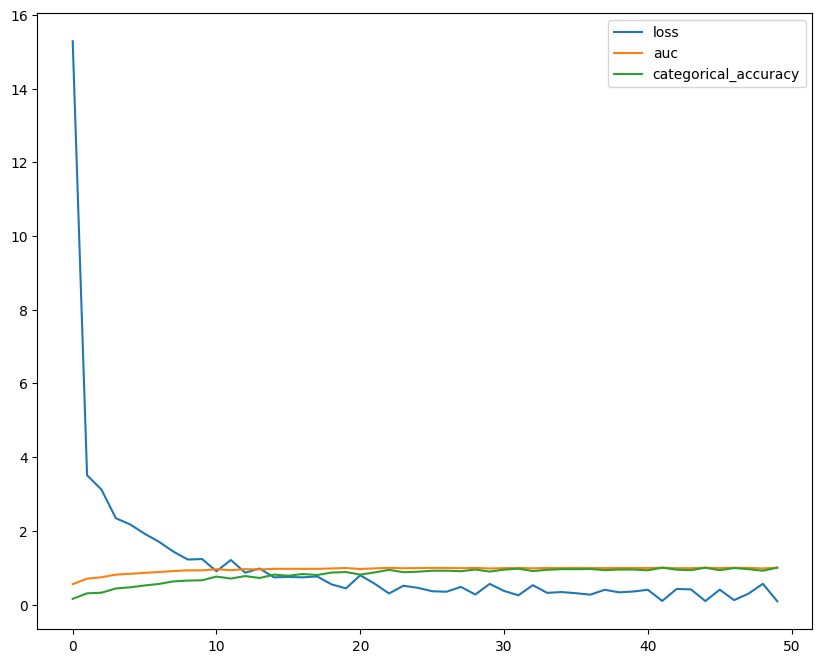

In [10]:
from datetime import datetime

# save the best weights
model_path = f"{root_dir_path}/mgr_models/vgg19_head_only_{datetime.now()}"

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    model_path,
    monitor='categorical_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch',
    initial_value_threshold=None
)

# fit the model
history = model.fit(training, epochs=50, verbose=1, callbacks=[checkpoint])
print("Best Training Accuracy: ", max(history.history["categorical_accuracy"]))
# print("Best Validation Accuracy: ", max(history.history["val_categorical_accuracy"]))
pd.DataFrame(history.history).plot(figsize=(10, 8))
plt.show()

#### Run Inference on Testset
Citation: https://www.kaggle.com/code/troymazerolle/using-vgg16-to-classify-spectrograms

In [11]:
from sklearn.metrics import accuracy_score

# load from file
# model_path = f"{root_dir_path}/vgg19_head_only_2024-04-21 15:00:35.654863"
# model = keras.models.load_model(model_path)


# run inference
pred_probalities = model.predict(testing)
predictions = np.argmax(pred_probalities, axis = 1)

# convert 1-hot categorical arrays to sparse vectors
ground_truth = [np.argmax(label, axis=-1) for _, label in testing.unbatch()]
ground_truth = tf.stack(ground_truth, axis = 0).numpy()
accuracy = accuracy_score(ground_truth, predictions)
print("Testset Accuracy:", accuracy)

3/3 [==============================] - 9s 4s/step
Testset Accuracy: 0.6666666666666666


#### Confusion Matrix

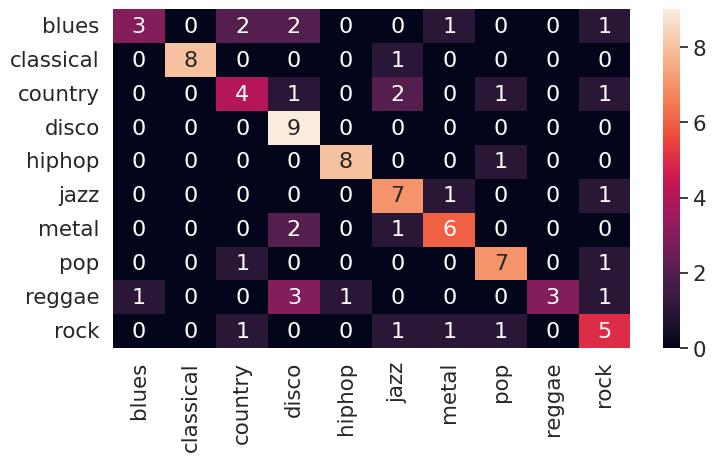


Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.33      0.46         9
           1       1.00      0.89      0.94         9
           2       0.50      0.44      0.47         9
           3       0.53      1.00      0.69         9
           4       0.89      0.89      0.89         9
           5       0.58      0.78      0.67         9
           6       0.67      0.67      0.67         9
           7       0.70      0.78      0.74         9
           8       1.00      0.33      0.50         9
           9       0.50      0.56      0.53         9

    accuracy                           0.67        90
   macro avg       0.71      0.67      0.66        90
weighted avg       0.71      0.67      0.66        90



In [12]:
from sklearn.metrics import classification_report, confusion_matrix

conf_mat = confusion_matrix(ground_truth, predictions)
conf_mat = np.round(conf_mat, 2)
conf_mat_df = pd.DataFrame(conf_mat, columns=genres, index=genres)

plt.figure(figsize = (8,5),)
sns.set(font_scale=1.4)
sns.heatmap(conf_mat_df, annot=True, annot_kws={"size": 16},) # font size
plt.tight_layout()
plt.show()
# plt.savefig(os.getcwd() + "/cnn_conf_mat1.png")

report = classification_report(ground_truth, predictions)
print('\nClassification Report:\n', report)

### Fine-tune VGG-19
* unfreeze the last convolution block (4 layers) to retrain the
complex features on spectograms, should improve performance given domain mismatch between imagenet images and melspectograms.

In [36]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=[keras.metrics.AUC(), keras.metrics.F1Score(), keras.metrics.CategoricalAccuracy()])
# save the best weights
model_path = f"{root_dir_path}/mgr_models/vgg19_head_only_{datetime.now()}"

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    model_path,
    monitor='categorical_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch',
    initial_value_threshold=None
)

# fit the model
# history = model.fit(training, epochs=10, verbose=1, callbacks=[checkpoint])
# print("Best Training Accuracy: ", max(history.history["categorical_accuracy"]))

# plt.plot(history.history["loss"])
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.legend(["Training Set"])

### K-folds Cross Validation
* evaluate finetuned model on the training set

#### Function def.

In [37]:
def k_folds_cross_val(model, k_folds_data, epochs, verbose=False):
  fold_histories = []
  best_accuracy = 0
  best_train_accuracy = 0
  # run k-folds
  for i in range(len(k_folds_data)):
    print(f"====================Fold {i+1}====================")
    # 1. assign this fold as validation set
    val_dataset = k_folds_data[i]

    # 2. create training dataset from other folds
    cross_val_train_dataset = None
    # find indexes of folds to concat
    fold_indices = [ind for ind in range(len(k_folds_data))]
    del fold_indices[i]

    # init training set with first fold
    if len(fold_indices) > 0:
      cross_val_train_dataset = k_folds_data[fold_indices[0]]
    del fold_indices[0]

    # add remaining folds
    for ind in fold_indices:
        cross_val_train_dataset = tf.data.Dataset.concatenate(cross_val_train_dataset, k_folds_data[ind])

    # 3. fit a model
    history = model.fit(cross_val_train_dataset, epochs=epochs, verbose=verbose, validation_data=val_dataset, callbacks=[checkpoint])
    if max(history.history["val_categorical_accuracy"]) > best_accuracy:
      best_accuracy = max(history.history["val_categorical_accuracy"])
    if max(history.history["categorical_accuracy"]) > best_train_accuracy:
      best_train_accuracy = max(history.history["categorical_accuracy"])
    fold_histories.append(history)
  if verbose:
    print("Best Validation Accuracy: ", best_accuracy)
    print("Best Training Accuracy: ", best_train_accuracy)

  return fold_histories, model

def average_cross_val_histories(histories, n_epochs, include_f1=True):
  n_folds = len(histories)
  final_history = {
      "loss": np.zeros((n_epochs)),
      # "auc": np.zeros((n_epochs)),
      "f1_score": np.zeros((n_epochs, len(genres))),
      "categorical_accuracy": np.zeros((n_epochs)),
      "val_loss": np.zeros((n_epochs)),
      # "val_auc": np.zeros((n_epochs)),
      "val_f1_score": np.zeros((n_epochs, len(genres))),
      "val_categorical_accuracy": np.zeros((n_epochs))
      }
  # accumulate values from all folds
  for history in histories:
    for metric, values in history.history.items():
        if metric not in final_history:
          final_history[metric] = np.zeros((n_epochs))
        val = np.array(values)
        final_history[metric] = np.add(final_history[metric], val)

  # take mean from all folds
  for metric, values in final_history.items():
      final_history[metric] = np.divide(final_history[metric], n_folds)
  if include_f1 is False:
    del final_history["f1_score"]
    del final_history["val_f1_score"]
  return final_history


#### Run K-Folds

In [38]:
# split training images into folds
n_folds = 10
n_epochs = 10
folds = get_training_data_fold(n_folds)
valid_folds = check_folds(folds, 890)
print(f"Valid Folds: {valid_folds}")

# prepare datasets
fold_datasets = [prepare_dataset(create_dataset(k_fold)) for k_fold in folds]
testing_dataset = prepare_dataset(create_dataset(spectogram_test))

# fit models
fold_histories, updated_model = k_folds_cross_val(model, fold_datasets, n_epochs, verbose=True)
model = updated_model
k_folds_validation_history = average_cross_val_histories(fold_histories, n_epochs, include_f1=False)

Valid Folds: True
====================Fold 1====================
Epoch 1/10
27/27 [==============================] - ETA: 0s - loss: 1.7391 - auc_5: 0.8714 - f1_score: 0.5268 - categorical_accuracy: 0.5381
Epoch 1: categorical_accuracy improved from -inf to 0.53808, saving model to /content/drive/MyDrive//mgr_models/vgg19_head_only_2024-04-22 10:33:45.608385
27/27 [==============================] - 20s 684ms/step - loss: 1.7391 - auc_5: 0.8714 - f1_score: 0.5268 - categorical_accuracy: 0.5381 - val_loss: 1.0195 - val_auc_5: 0.9876 - val_f1_score: 0.9116 - val_categorical_accuracy: 0.9101
Epoch 2/10
27/27 [==============================] - ETA: 0s - loss: 0.7331 - auc_5: 0.9929 - f1_score: 0.9166 - categorical_accuracy: 0.9176
Epoch 2: categorical_accuracy improved from 0.53808 to 0.91760, saving model to /content/drive/MyDrive//mgr_models/vgg19_head_only_2024-04-22 10:33:45.608385
27/27 [==============================] - 9s 349ms/step - loss: 0.7331 - auc_5: 0.9929 - f1_score: 0.9166 -

#### Loss Plot

{'loss': array([0.2192742 , 0.11864486, 0.07518999, 0.05798462, 0.05276167,
       0.05119314, 0.05072477, 0.05049515, 0.05040487, 0.0503461 ]), 'categorical_accuracy': array([0.95380774, 0.9917603 , 0.99812734, 0.99987516, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 'val_loss': array([0.14729514, 0.08830001, 0.06357113, 0.0545469 , 0.05167462,
       0.050818  , 0.05053925, 0.0504269 , 0.05036295, 0.05031871]), 'val_categorical_accuracy': array([0.99101124, 0.99550562, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ]), 'auc_5': array([0.98713557, 0.99929408, 0.9999682 , 0.99999996, 1.        ,
       1.        , 0.99999999, 1.        , 1.        , 1.        ]), 'val_auc_5': array([0.99876418, 0.99992425, 1.        , 0.99999999, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])}


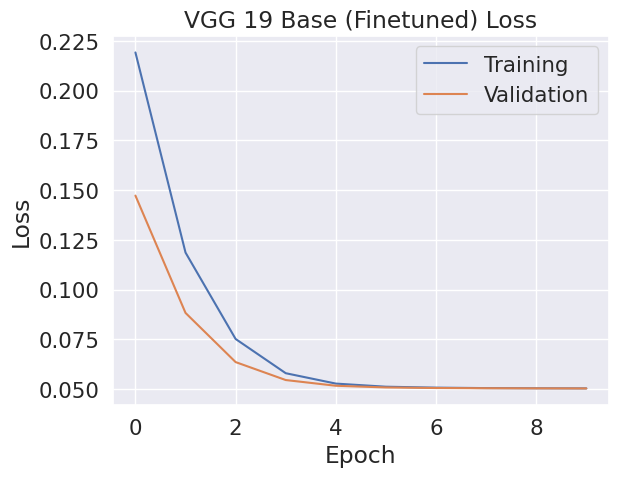

In [39]:
print(k_folds_validation_history)
plt.plot(k_folds_validation_history["loss"])
plt.plot(k_folds_validation_history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VGG 19 Base (Finetuned) Loss")
plt.legend(["Training", "Validation"])

#### Accuracy Plot

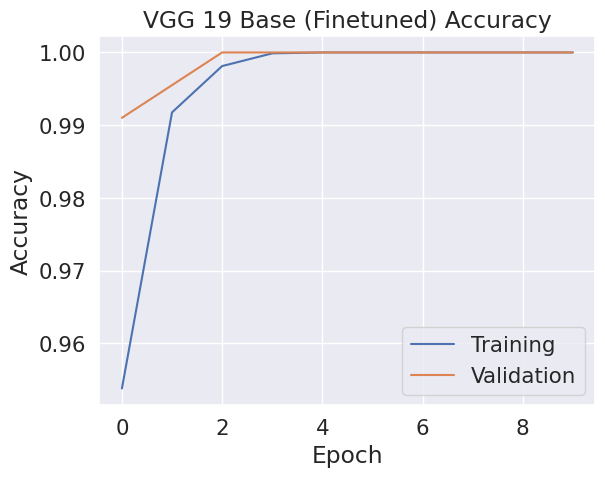

In [40]:
# pd.DataFrame(k_folds_validation_history).plot(figsize=(10, 8))
plt.plot(k_folds_validation_history["categorical_accuracy"])
plt.plot(k_folds_validation_history["val_categorical_accuracy"])
plt.legend(["Training", "Validation"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("VGG 19 Base (Finetuned) Accuracy")
plt.show()

### Evaluating **finetuned** Testset Performance
* fits the model to the full training dataset
* saves checkpointed weights in 'mgr_models/vgg19_finetuned_{*current time*}
* runs inference on the test dataset

#### Model Training
* fits the full training dataset to the model, with best hyperparams from k-folds

Epoch 1/50
28/28 [==============================] - ETA: 0s - loss: 1.8363 - auc_6: 0.8776 - f1_score: 0.5180 - categorical_accuracy: 0.5191
Epoch 1: categorical_accuracy improved from -inf to 0.51910, saving model to /content/mgr_models/vgg19_head_only_2024-04-21 00:49:09.416525
28/28 [==============================] - 10s 374ms/step - loss: 1.8363 - auc_6: 0.8776 - f1_score: 0.5180 - categorical_accuracy: 0.5191
Epoch 2/50
28/28 [==============================] - ETA: 0s - loss: 1.5756 - auc_6: 0.8993 - f1_score: 0.5861 - categorical_accuracy: 0.5899
Epoch 2: categorical_accuracy improved from 0.51910 to 0.58989, saving model to /content/mgr_models/vgg19_head_only_2024-04-21 00:49:09.416525
28/28 [==============================] - 10s 365ms/step - loss: 1.5756 - auc_6: 0.8993 - f1_score: 0.5861 - categorical_accuracy: 0.5899
Epoch 3/50
28/28 [==============================] - ETA: 0s - loss: 1.2602 - auc_6: 0.9329 - f1_score: 0.6584 - categorical_accuracy: 0.6596
Epoch 3: categorical

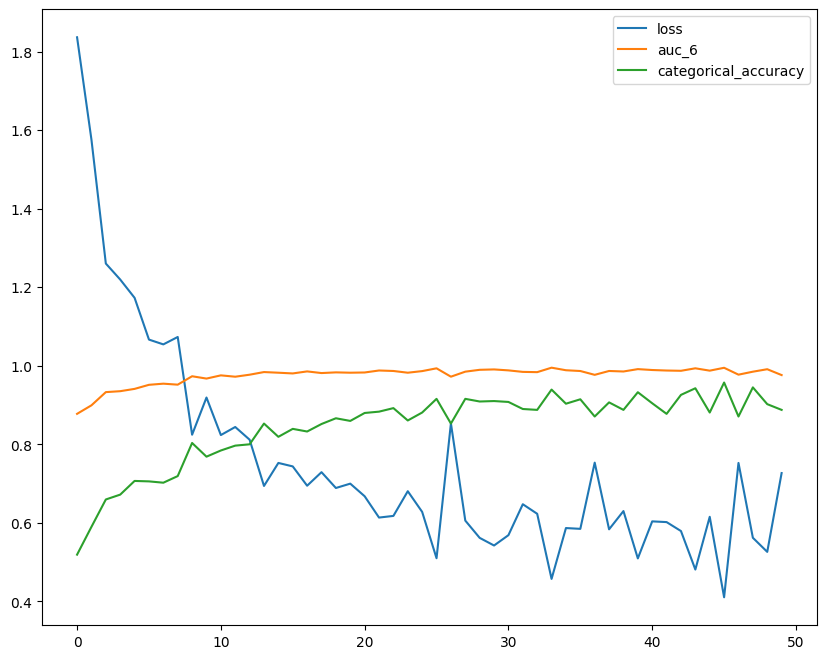

In [ ]:
from datetime import datetime

# save the best weights
model_path = f"{root_dir_path}/mgr_models/vgg19_finetuned_{datetime.now()}"

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    model_path,
    monitor='categorical_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch',
    initial_value_threshold=None
)

# fit the model
history = model.fit(training, epochs=50, verbose=1, callbacks=[checkpoint])
print("Best Training Accuracy: ", max(history.history["categorical_accuracy"]))
# print("Best Validation Accuracy: ", max(history.history["val_categorical_accuracy"]))
# pd.DataFrame(history.history).plot(figsize=(10, 8))
# plt.show()

#### Loss Plot

In [ ]:
print(history)
plt.plot(history["loss"])
plt.plot(history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VGG 19 Base (Finetuned) Loss")
plt.legend(["Training", "Validation"])

#### Accuracy Plot

In [ ]:
plt.plot(history["categorical_accuracy"])
plt.plot(history["val_categorical_accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("VGG 19 Base (Finetuned Accuracy")
plt.legend(["Training", "Validation"])

#### Run Inference on Testset
Citation: https://www.kaggle.com/code/troymazerolle/using-vgg16-to-classify-spectrograms

In [41]:
from sklearn.metrics import accuracy_score

# load from file
# model_path = f"{root_dir_path}/vgg19_head_only_2024-04-21 00:49:09.416525"
# model = keras.models.load_model(model_path)


# run inference
pred_probalities = model.predict(testing)
predictions = np.argmax(pred_probalities, axis = 1)

# convert 1-hot categorical arrays to sparse vectors
ground_truth = [np.argmax(label, axis=-1) for _, label in testing.unbatch()]
ground_truth = tf.stack(ground_truth, axis = 0).numpy()
accuracy = accuracy_score(ground_truth, predictions)
print("Testset Accuracy:", accuracy)

4/4 [==============================] - 1s 259ms/step
Testset Accuracy: 0.06


#### Confusion Matrix

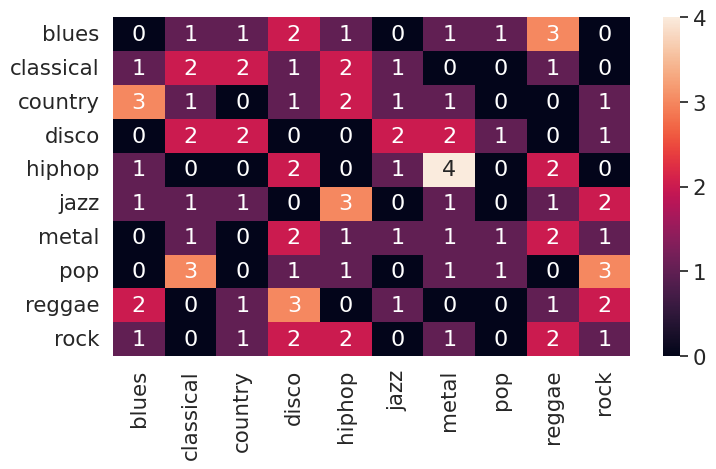


Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.18      0.20      0.19        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.08      0.10      0.09        10
           7       0.25      0.10      0.14        10
           8       0.08      0.10      0.09        10
           9       0.09      0.10      0.10        10

    accuracy                           0.06       100
   macro avg       0.07      0.06      0.06       100
weighted avg       0.07      0.06      0.06       100



In [42]:
from sklearn.metrics import classification_report, confusion_matrix

conf_mat = confusion_matrix(ground_truth, predictions)
conf_mat = np.round(conf_mat, 2)
conf_mat_df = pd.DataFrame(conf_mat, columns=genres, index=genres)

plt.figure(figsize = (8,5),)
sns.set(font_scale=1.4)
sns.heatmap(conf_mat_df, annot=True, annot_kws={"size": 16},) # font size
plt.tight_layout()
plt.show()
# plt.savefig(os.getcwd() + "/cnn_conf_mat1.png")

report = classification_report(ground_truth, predictions)
print('\nClassification Report:\n', report)